In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'savefig.dpi': 1200})

import os, random, time, pickle, torch
import numpy as np
import torchvision.transforms.functional as F

from roarena import attacker

job = attacker.AttackJob('save/adversarial_attacks')
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
IMG_SIZE = 32

/foolbox/foolbox/attacks/brendel_bethge.py:624: UserWarning: At the first initialisation the optimizer needs to be compiled. This may take between 20 to 60 seconds.
  warnings.warn(


In [2]:
from jarvis.utils import match_cond

model_pth = 'save/models/CIFAR10.ResNet50_base.pt'
model_tag = 'robust'

metric, name, is_targeted = 'Linf', 'PGD', False
batch_size, batch_idx = 25, 6
eps_level = 8

cond = {
    'attack_config': {
        'model_pth': model_pth,
        'metric': metric, 'name': name, 'is_targeted': is_targeted,
        'batch_size': batch_size, 'batch_idx': batch_idx,
        'eps_level': eps_level,
    },
}

w_ids = [w_id for w_id in job.configs.fetch_conditioned(cond) if job.is_completed(w_id)]

In [3]:
from jarvis.vision import prepare_datasets

dataset = prepare_datasets('CIFAR10', 'vision_datasets')
device = 'cuda'

images, _ = attacker.prepare_batch(dataset, batch_size, batch_idx, False, device)
images = images.raw.cpu()

advs, successes, dists = [], [], []
for w_id in w_ids:
    output = job.outputs.fetch_record(w_id)
    advs.append(output['advs'])
    successes.append(output['successes'])
    dists.append(output['dists'])
advs = np.stack(advs)
successes = np.stack(successes)
dists = np.stack(dists)

best_idxs = []
for img_idx in range(len(images)):
    _success_idxs, = successes[:, img_idx].nonzero()
    if len(_success_idxs)>0:
        best_idx = random.choice(_success_idxs)
    else:
        best_idx = random.choice(range(len(w_ids)))
    best_idxs.append(best_idx)
advs = torch.tensor(np.stack([advs[best_idx, img_idx] for img_idx, best_idx in enumerate(best_idxs)]), dtype=torch.float)
successes = np.stack([successes[best_idx, img_idx] for img_idx, best_idx in enumerate(best_idxs)])
dists = np.stack([dists[best_idx, img_idx] for img_idx, best_idx in enumerate(best_idxs)])

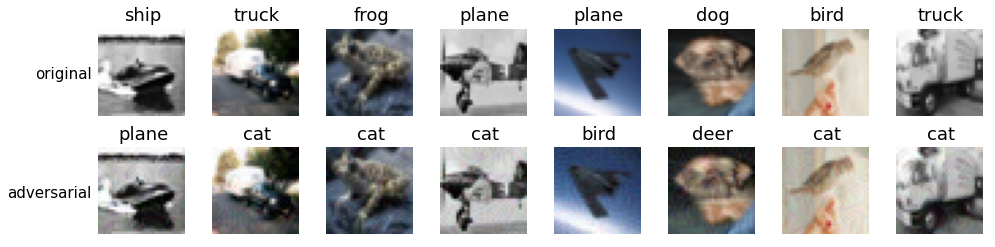

In [4]:
model = torch.load(model_pth)['model']
model.eval().to(device)

with torch.no_grad():
    logits = model(images.to(device))
    _, predicts_orig = logits.max(dim=1)
predicts_orig = predicts_orig.cpu()

with torch.no_grad():
    logits = model(advs.to(device))
    _, predicts_adv = logits.max(dim=1)
predicts_adv = predicts_adv.cpu()

sample_num = 8
fig, axes = plt.subplots(2, sample_num, figsize=(2*sample_num, 4))
for i in range(sample_num):
    ax = axes[0, i]
    ax.imshow(images[i].permute(1, 2, 0))
    ax.set_title(class_names[predicts_orig[i]])
    
    ax = axes[1, i]
    ax.imshow(advs[i].permute(1, 2, 0))
    ax.set_title(class_names[predicts_adv[i]])
axes[0, 0].set_ylabel('original', rotation='horizontal', horizontalalignment='right', verticalalignment='center')
axes[1, 0].set_ylabel('adversarial', rotation='horizontal', horizontalalignment='right', verticalalignment='center')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-1.5, IMG_SIZE+1.5])
    ax.set_ylim([IMG_SIZE+1.5, -1.5])
    for s in ax.spines.values():
        s.set_visible(False)
plt.show()
fig.savefig(f'figs/{model_tag}_adv.svg')

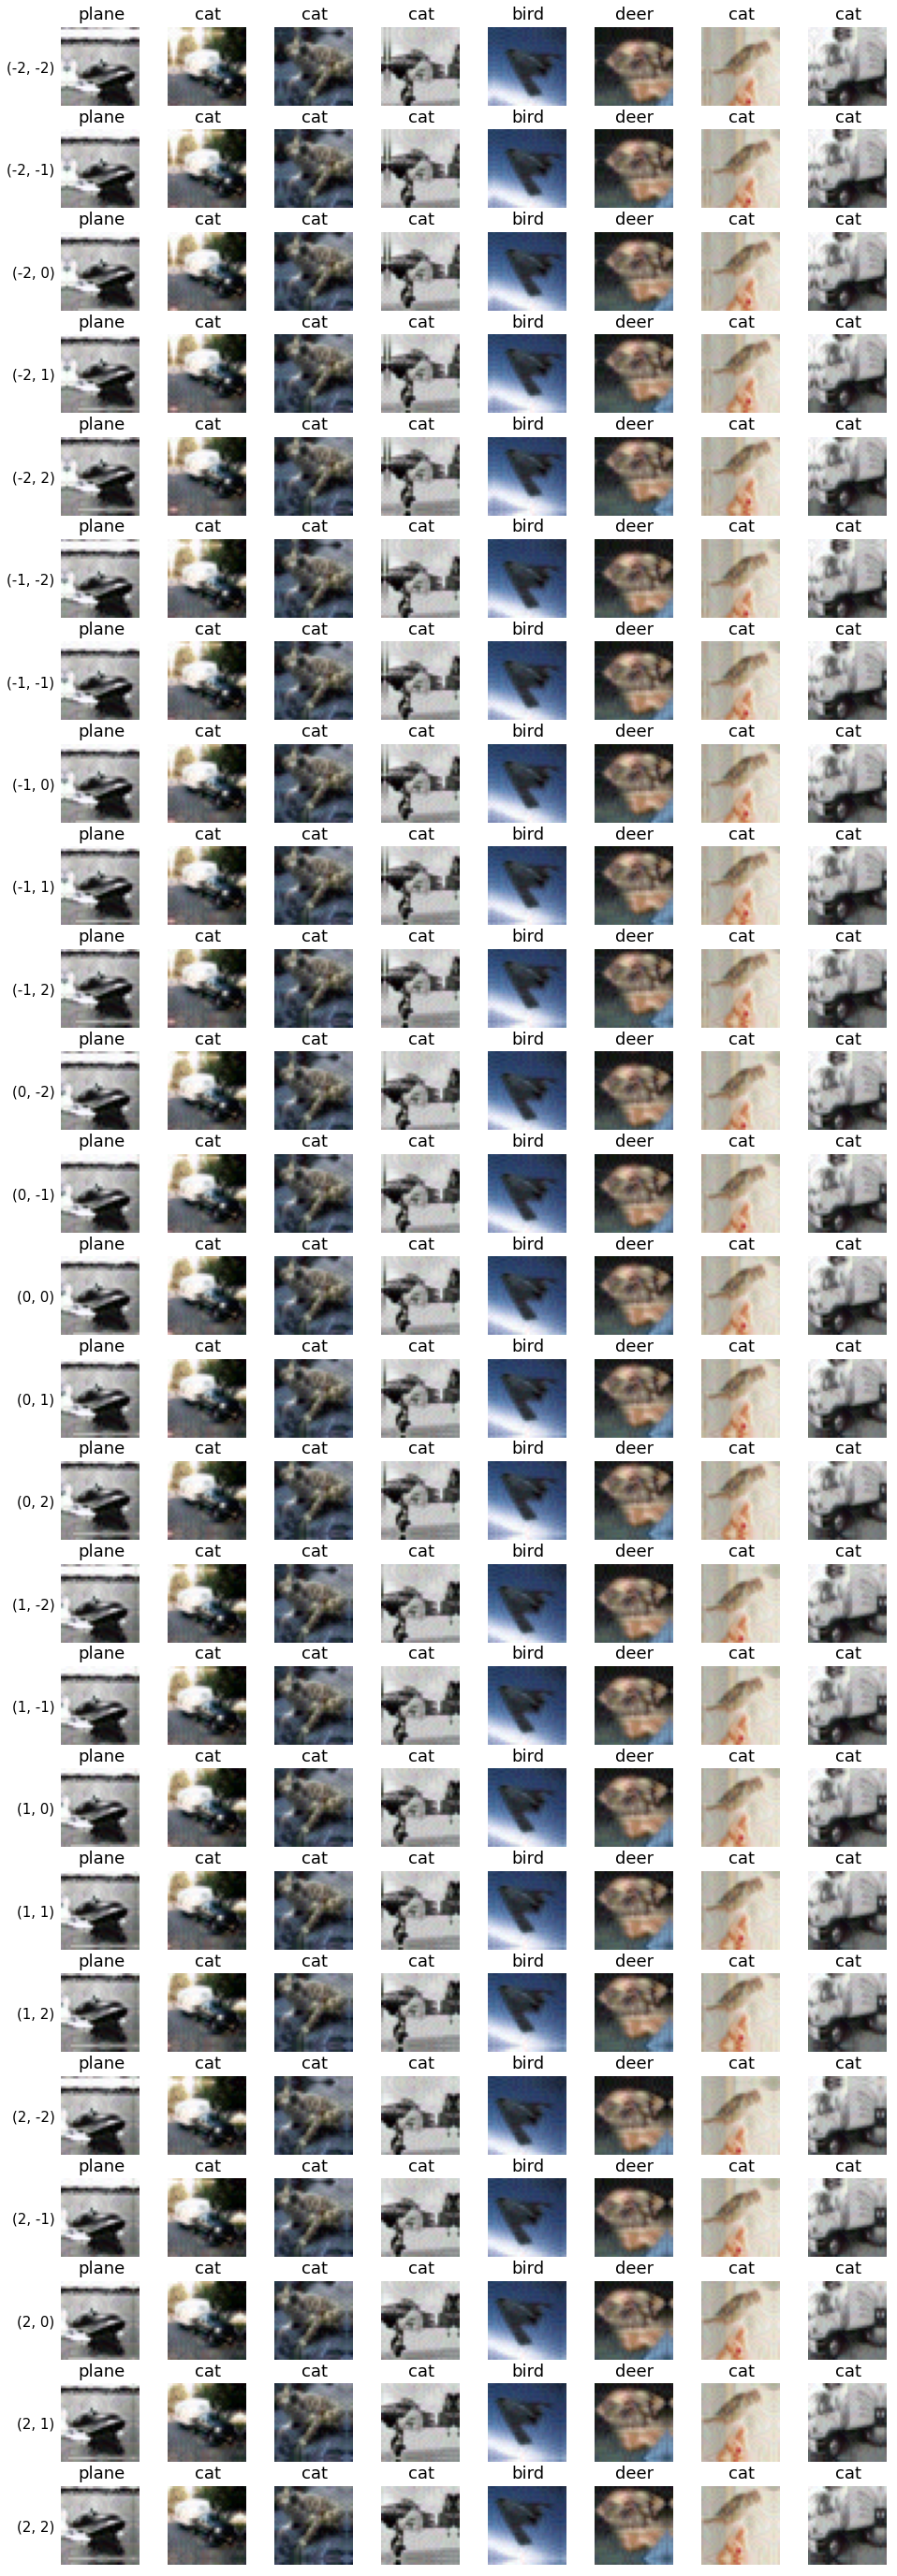

In [5]:
jitter = 2
fig, axes = plt.subplots((jitter*2+1)**2, sample_num, figsize=(2*sample_num, 2*(jitter*2+1)**2))
row_idx = 0
for dx in range(-jitter, jitter+1):
    for dy in range(-jitter, jitter+1):
        _advs = F.crop(F.pad(advs, jitter, padding_mode='reflect'), dy+jitter, dx+jitter, IMG_SIZE, IMG_SIZE)
        with torch.no_grad():
            logits = model(_advs.to(device))
            _, predicts_aug = logits.max(dim=1)
        predicts_aug = predicts_aug.cpu()
        
        for i in range(sample_num):
            ax = axes[row_idx, i]
            ax.imshow(_advs[i].permute(1, 2, 0))
            ax.set_title(class_names[predicts_aug[i]])
        axes[row_idx, 0].set_ylabel('({}, {})'.format(dx, dy), rotation='horizontal', horizontalalignment='right', verticalalignment='center')
        row_idx += 1
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-1.5, IMG_SIZE+1.5])
    ax.set_ylim([IMG_SIZE+1.5, -1.5])
    for s in ax.spines.values():
        s.set_visible(False)
plt.show()
fig.savefig(f'figs/{model_tag}_jitter.svg')

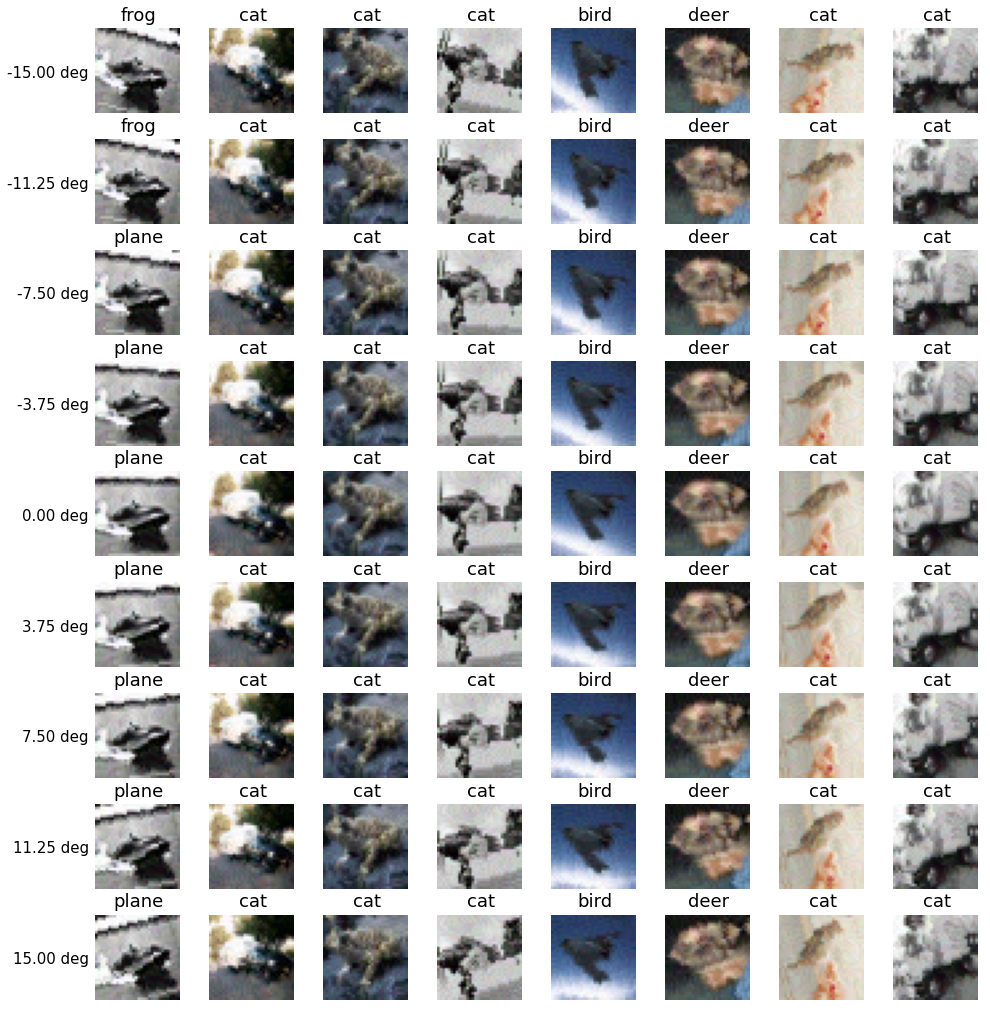

In [6]:
pad = 8
fig, axes = plt.subplots(9, sample_num, figsize=(2*sample_num, 2*9))
for row_idx, angle in enumerate(np.linspace(-15, 15, 9)):
    _advs = F.crop(F.rotate(F.pad(advs, pad, padding_mode='reflect'), angle), pad, pad, IMG_SIZE, IMG_SIZE)
    with torch.no_grad():
        logits = model(_advs.to(device))
        _, predicts_aug = logits.max(dim=1)
    predicts_aug = predicts_aug.cpu()
        
    for i in range(sample_num):
        ax = axes[row_idx, i]
        ax.imshow(_advs[i].permute(1, 2, 0))
        ax.set_title(class_names[predicts_aug[i]])
    axes[row_idx, 0].set_ylabel('{:.2f} deg'.format(angle), rotation='horizontal', horizontalalignment='right', verticalalignment='center')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-1.5, IMG_SIZE+1.5])
    ax.set_ylim([IMG_SIZE+1.5, -1.5])
    for s in ax.spines.values():
        s.set_visible(False)
plt.show()
fig.savefig(f'figs/{model_tag}_rotate.svg')

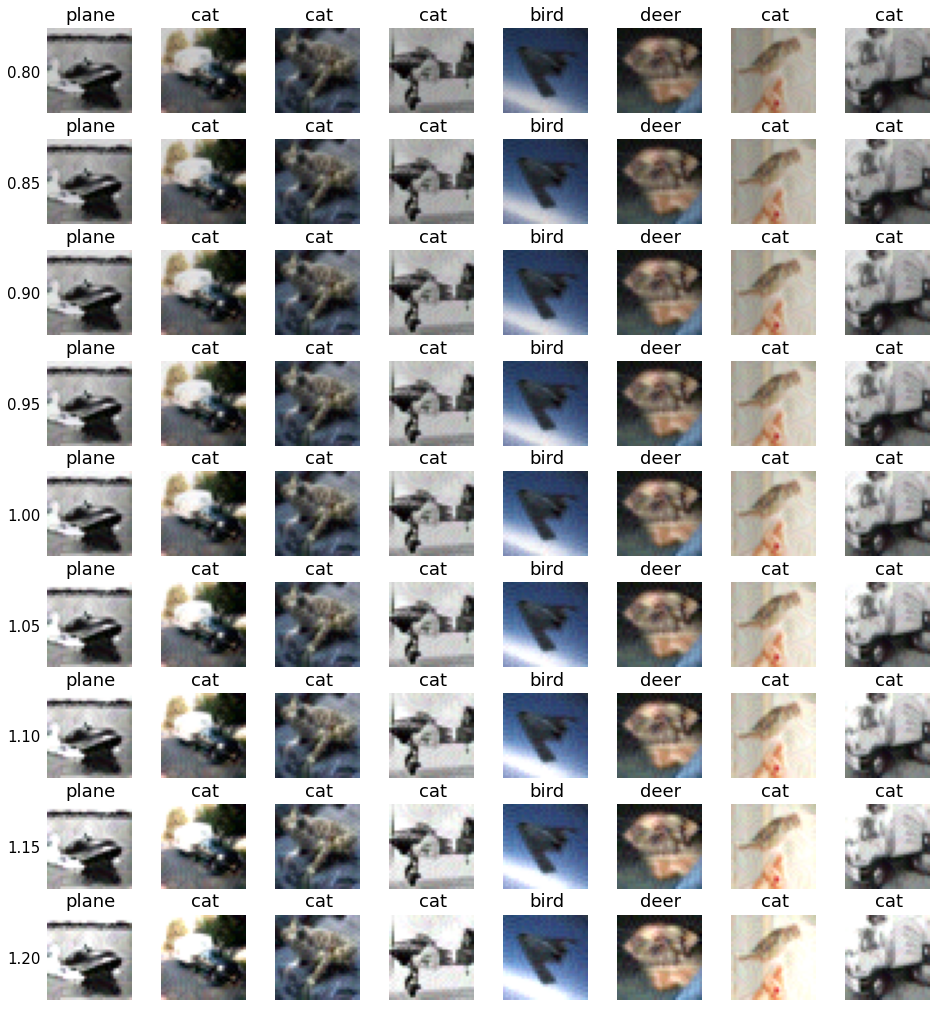

In [7]:
fig, axes = plt.subplots(9, sample_num, figsize=(2*sample_num, 2*9))
for row_idx, brightness in enumerate(np.linspace(0.8, 1.2, 9)):
    _advs = F.adjust_brightness(advs, brightness)
    with torch.no_grad():
        logits = model(_advs.to(device))
        _, predicts_aug = logits.max(dim=1)
    predicts_aug = predicts_aug.cpu()
        
    for i in range(sample_num):
        ax = axes[row_idx, i]
        ax.imshow(_advs[i].permute(1, 2, 0))
        ax.set_title(class_names[predicts_aug[i]])
    axes[row_idx, 0].set_ylabel('{:.2f}'.format(brightness), rotation='horizontal', horizontalalignment='right', verticalalignment='center')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-1.5, IMG_SIZE+1.5])
    ax.set_ylim([IMG_SIZE+1.5, -1.5])
    for s in ax.spines.values():
        s.set_visible(False)
plt.show()
fig.savefig(f'figs/{model_tag}_brightness.svg')

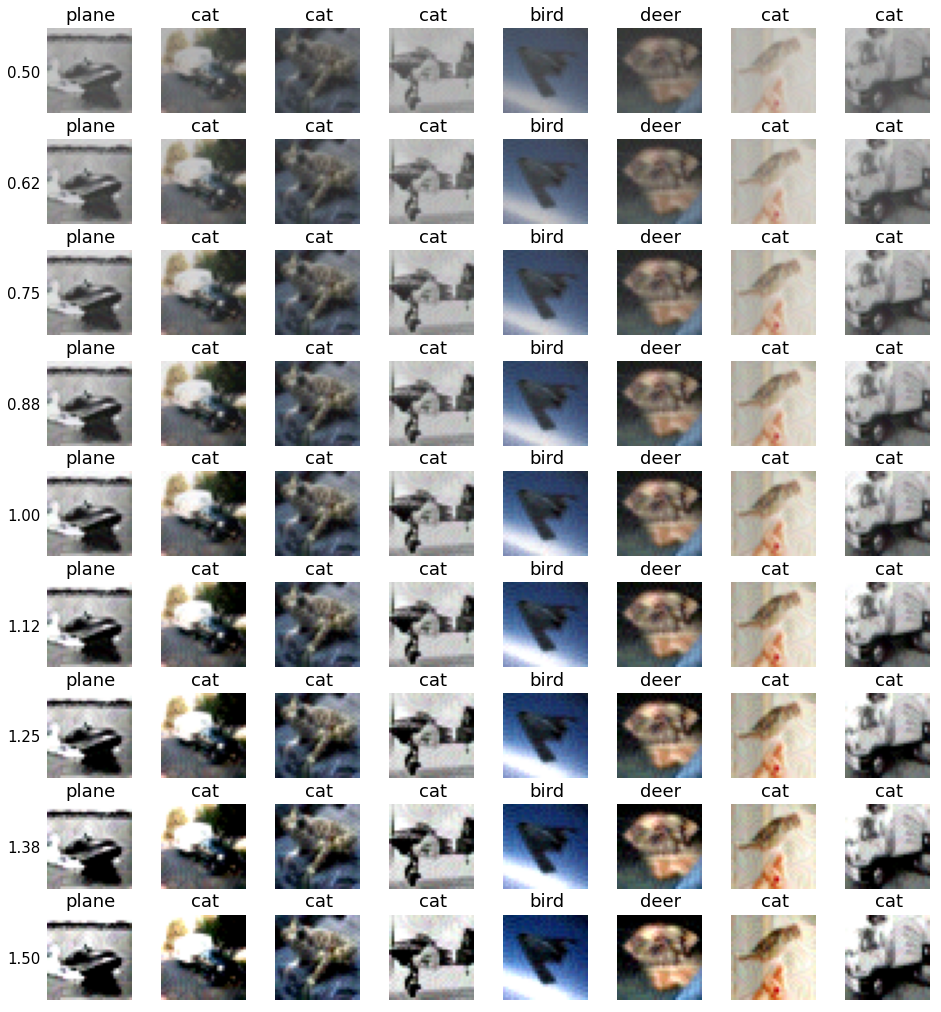

In [8]:
fig, axes = plt.subplots(9, sample_num, figsize=(2*sample_num, 2*9))
for row_idx, contrast in enumerate(np.linspace(0.5, 1.5, 9)):
    _advs = F.adjust_contrast(advs, contrast)
    with torch.no_grad():
        logits = model(_advs.to(device))
        _, predicts_aug = logits.max(dim=1)
    predicts_aug = predicts_aug.cpu()
        
    for i in range(sample_num):
        ax = axes[row_idx, i]
        ax.imshow(_advs[i].permute(1, 2, 0))
        ax.set_title(class_names[predicts_aug[i]])
    axes[row_idx, 0].set_ylabel('{:.2f}'.format(contrast), rotation='horizontal', horizontalalignment='right', verticalalignment='center')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-1.5, IMG_SIZE+1.5])
    ax.set_ylim([IMG_SIZE+1.5, -1.5])
    for s in ax.spines.values():
        s.set_visible(False)
plt.show()
fig.savefig(f'figs/{model_tag}_contrast.svg')

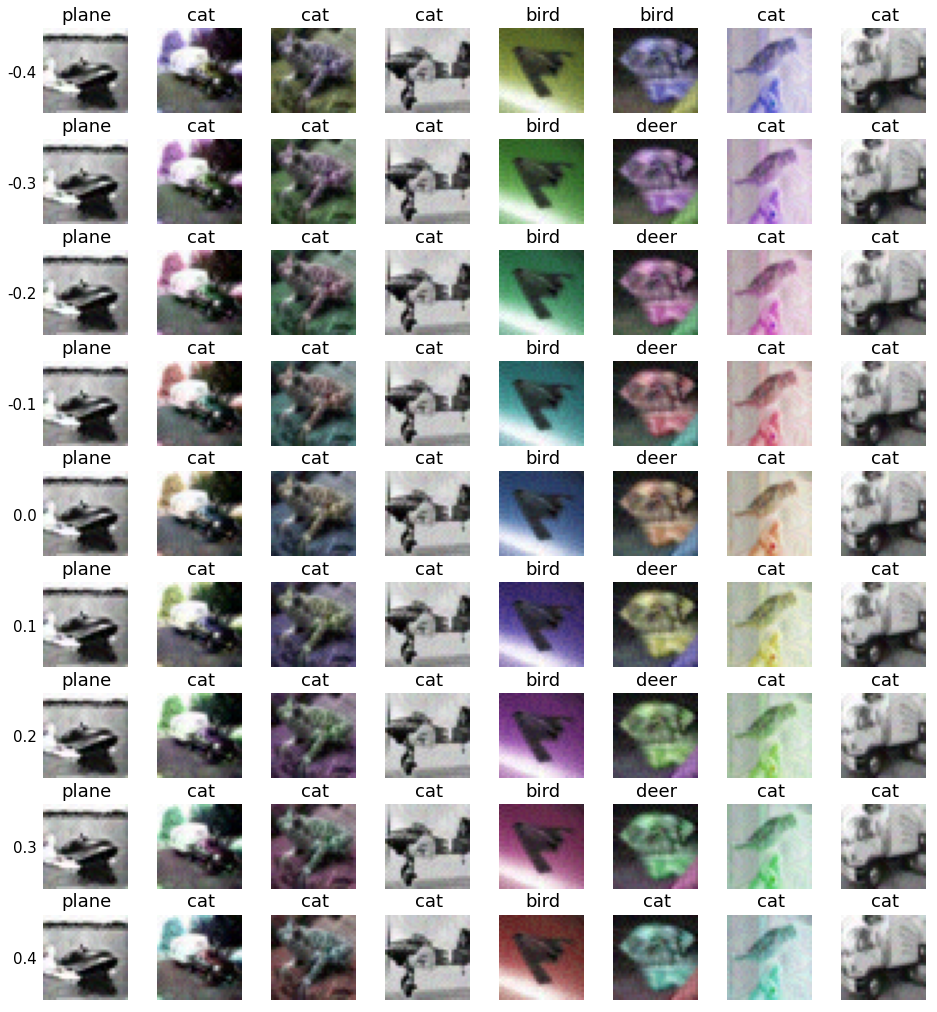

In [9]:
fig, axes = plt.subplots(9, sample_num, figsize=(2*sample_num, 2*9))
for row_idx, hue in enumerate(np.linspace(-0.4, 0.4, 9)):
    _advs = F.adjust_hue(advs, hue)
    with torch.no_grad():
        logits = model(_advs.to(device))
        _, predicts_aug = logits.max(dim=1)
    predicts_aug = predicts_aug.cpu()
        
    for i in range(sample_num):
        ax = axes[row_idx, i]
        ax.imshow(_advs[i].permute(1, 2, 0))
        ax.set_title(class_names[predicts_aug[i]])
    axes[row_idx, 0].set_ylabel('{:.1f}'.format(hue), rotation='horizontal', horizontalalignment='right', verticalalignment='center')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim([-1.5, IMG_SIZE+1.5])
    ax.set_ylim([IMG_SIZE+1.5, -1.5])
    for s in ax.spines.values():
        s.set_visible(False)
plt.show()
fig.savefig(f'figs/{model_tag}_hue.svg')